In [1]:
# !pip install torch-summary

In [2]:
import os
import torch
import torchvision
from torchsummary import summary
import tarfile
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torchvision import datasets
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset
from torch.cuda.amp import autocast
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
transforms_func = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_datasets = datasets.ImageFolder(
    '/kaggle/input/25-classes-classificatin/Seen/bird dataset/train',
    transform=transforms_func
)
val_datasets = datasets.ImageFolder(
    '/kaggle/input/25-classes-classificatin/Seen/bird dataset/val',
    transform=transforms_func
)

In [4]:
batch_size = 32
train_dataloader = DataLoader(train_datasets, batch_size=batch_size,num_workers=4,shuffle=True)
val_dataloader = DataLoader(val_datasets, batch_size=batch_size,num_workers=4,shuffle=False)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()
device

device(type='cuda')

In [7]:
train_dl = DeviceDataLoader(train_dataloader, device)
valid_dl = DeviceDataLoader(val_dataloader, device)

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Evaluation(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out,labels)          # Calculate accuracy
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'],result['train_acc'], result['val_loss'], result['val_acc']))

In [9]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class CustomModel(Evaluation):
    def __init__(self, block, num_blocks, num_classes=25):
        super(CustomModel, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [10]:
model = to_device(CustomModel(BasicBlock, [2, 2, 2, 2], num_classes=25),device)
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 147,456
|    |    └─BatchNorm2d: 3-14        

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 147,456
|    |    └─BatchNorm2d: 3-14        

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def modeltrain(epochs, lr, model, train_loader, val_loader, 
                  weight_decay=0,grad_clip=None, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    torch.cuda.empty_cache()
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []

        for batch in tqdm(train_loader):
            batch = to_device(batch,device)
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()

        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.2199831008911133, 'val_acc': 0.033510636538267136}]

In [13]:
epochs = 50
lr = 1e-3
weight_decay = 1e-4
grad_clip = 0.1
opt_func = torch.optim.Adam

In [14]:
%%time
history += modeltrain(epochs, lr, model, train_dl, valid_dl,  
                            weight_decay=weight_decay, 
                            grad_clip = grad_clip,
                            opt_func=opt_func)

100%|██████████| 704/704 [02:06<00:00,  5.57it/s]


Epoch [0], train_loss: 2.4681,train_acc: 0.2211, val_loss: 2.3812, val_acc: 0.2571


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [1], train_loss: 1.9598,train_acc: 0.3636, val_loss: 1.9526, val_acc: 0.3789


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [2], train_loss: 1.6709,train_acc: 0.4594, val_loss: 1.7339, val_acc: 0.4479


100%|██████████| 704/704 [02:04<00:00,  5.63it/s]


Epoch [3], train_loss: 1.3861,train_acc: 0.5598, val_loss: 1.5695, val_acc: 0.5074


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [4], train_loss: 1.1050,train_acc: 0.6540, val_loss: 1.1088, val_acc: 0.6579


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [5], train_loss: 0.8905,train_acc: 0.7207, val_loss: 0.8296, val_acc: 0.7458


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [6], train_loss: 0.7298,train_acc: 0.7727, val_loss: 0.8400, val_acc: 0.7408


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [7], train_loss: 0.6211,train_acc: 0.8075, val_loss: 0.7863, val_acc: 0.7608


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [8], train_loss: 0.5395,train_acc: 0.8348, val_loss: 0.9110, val_acc: 0.7046


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [9], train_loss: 0.4889,train_acc: 0.8486, val_loss: 0.5362, val_acc: 0.8348


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [10], train_loss: 0.4027,train_acc: 0.8777, val_loss: 0.6841, val_acc: 0.8112


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [11], train_loss: 0.3556,train_acc: 0.8900, val_loss: 0.7007, val_acc: 0.8013


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [12], train_loss: 0.3296,train_acc: 0.8970, val_loss: 0.5410, val_acc: 0.8389


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [13], train_loss: 0.2788,train_acc: 0.9107, val_loss: 0.4957, val_acc: 0.8518


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [14], train_loss: 0.2609,train_acc: 0.9177, val_loss: 0.5315, val_acc: 0.8398


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [15], train_loss: 0.2489,train_acc: 0.9247, val_loss: 0.7296, val_acc: 0.7979


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [16], train_loss: 0.2156,train_acc: 0.9341, val_loss: 0.6496, val_acc: 0.8231


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [17], train_loss: 0.1865,train_acc: 0.9431, val_loss: 0.4989, val_acc: 0.8513


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [18], train_loss: 0.2075,train_acc: 0.9354, val_loss: 0.4543, val_acc: 0.8614


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [19], train_loss: 0.1705,train_acc: 0.9482, val_loss: 0.4495, val_acc: 0.8703


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [20], train_loss: 0.1559,train_acc: 0.9519, val_loss: 0.4871, val_acc: 0.8581


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [21], train_loss: 0.1460,train_acc: 0.9534, val_loss: 0.4735, val_acc: 0.8650


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [22], train_loss: 0.1453,train_acc: 0.9541, val_loss: 0.6917, val_acc: 0.8289


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [23], train_loss: 0.1419,train_acc: 0.9566, val_loss: 0.6461, val_acc: 0.8290


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [24], train_loss: 0.1368,train_acc: 0.9579, val_loss: 0.6298, val_acc: 0.8288


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [25], train_loss: 0.1315,train_acc: 0.9583, val_loss: 0.4916, val_acc: 0.8614


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [26], train_loss: 0.1249,train_acc: 0.9613, val_loss: 0.4626, val_acc: 0.8693


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [27], train_loss: 0.1078,train_acc: 0.9665, val_loss: 0.6123, val_acc: 0.8395


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [28], train_loss: 0.1137,train_acc: 0.9654, val_loss: 0.6470, val_acc: 0.8482


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [29], train_loss: 0.1050,train_acc: 0.9683, val_loss: 0.4871, val_acc: 0.8694


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [30], train_loss: 0.1021,train_acc: 0.9694, val_loss: 0.4384, val_acc: 0.8801


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [31], train_loss: 0.1039,train_acc: 0.9679, val_loss: 0.7833, val_acc: 0.8080


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [32], train_loss: 0.1271,train_acc: 0.9619, val_loss: 0.5195, val_acc: 0.8676


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [33], train_loss: 0.1024,train_acc: 0.9682, val_loss: 0.4264, val_acc: 0.8801


100%|██████████| 704/704 [02:05<00:00,  5.60it/s]


Epoch [34], train_loss: 0.0864,train_acc: 0.9728, val_loss: 0.4869, val_acc: 0.8710


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [35], train_loss: 0.0981,train_acc: 0.9704, val_loss: 0.5722, val_acc: 0.8459


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [36], train_loss: 0.0981,train_acc: 0.9693, val_loss: 0.6125, val_acc: 0.8591


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [37], train_loss: 0.0995,train_acc: 0.9699, val_loss: 0.5493, val_acc: 0.8543


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [38], train_loss: 0.0850,train_acc: 0.9752, val_loss: 0.4252, val_acc: 0.8893


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [39], train_loss: 0.0933,train_acc: 0.9723, val_loss: 0.5597, val_acc: 0.8469


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [40], train_loss: 0.0876,train_acc: 0.9745, val_loss: 0.4817, val_acc: 0.8650


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [41], train_loss: 0.0986,train_acc: 0.9701, val_loss: 0.5101, val_acc: 0.8649


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [42], train_loss: 0.0962,train_acc: 0.9717, val_loss: 0.4484, val_acc: 0.8787


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [43], train_loss: 0.0853,train_acc: 0.9757, val_loss: 0.7449, val_acc: 0.8069


100%|██████████| 704/704 [02:05<00:00,  5.63it/s]


Epoch [44], train_loss: 0.0997,train_acc: 0.9718, val_loss: 0.4284, val_acc: 0.8860


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [45], train_loss: 0.0716,train_acc: 0.9804, val_loss: 0.4681, val_acc: 0.8703


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [46], train_loss: 0.0922,train_acc: 0.9727, val_loss: 0.4889, val_acc: 0.8659


100%|██████████| 704/704 [02:05<00:00,  5.62it/s]


Epoch [47], train_loss: 0.0929,train_acc: 0.9710, val_loss: 0.4612, val_acc: 0.8825


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [48], train_loss: 0.0866,train_acc: 0.9743, val_loss: 0.5122, val_acc: 0.8652


100%|██████████| 704/704 [02:05<00:00,  5.61it/s]


Epoch [49], train_loss: 0.0767,train_acc: 0.9773, val_loss: 0.4396, val_acc: 0.8808
CPU times: user 1h 46min, sys: 14min 23s, total: 2h 23s
Wall time: 2h 2min 6s


In [15]:
torch.save(model.state_dict(), 'model.pt')

In [17]:
def plot_accuracies(history):
    train_accs =[x.get('train_acc') for x in history]
    val_accs = [x['val_acc'] for x in history]
    plt.plot(train_accs,'-b')
    plt.plot(val_accs, '-r')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('accuracy.png');

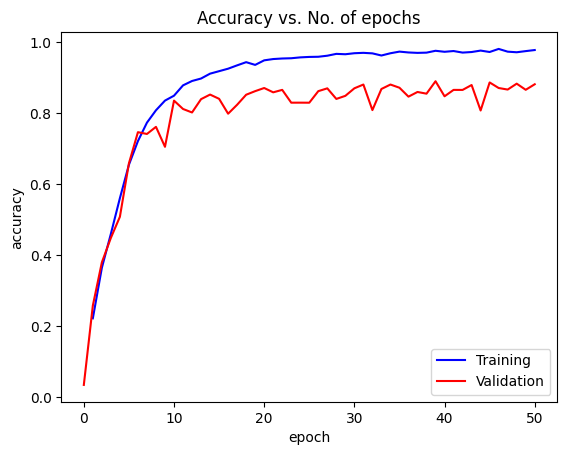

In [18]:
plot_accuracies(history)

In [19]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('losses.png');

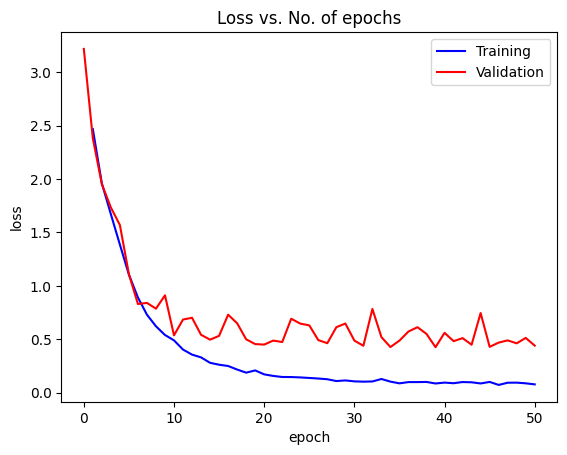

In [20]:
plot_losses(history)